In [1]:
import gym
import collections
from tensorboardX import SummaryWriter
ENV_NAME = "FrozenLake-v1"

c:\Users\Administrateur\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
GAMMA = 0.9
TEST_EPISODES = 20

In [6]:
# we define the Agent class, which will keep our tables and
# contain functions that we will be using in the training loop
class Agent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.state = self.env.reset()[0]
        self.rewards = collections.defaultdict(float)
        self.transits = collections.defaultdict(collections.Counter) #transition table
        self.values = collections.defaultdict(float)  #value table

    def play_n_random_steps(self, count):
        for _ in range(count):
            action = self.env.action_space.sample()
            new_state, reward, is_done, _,_ = self.env.step(action)
            #self.rewards[(self.state, action, new_state)] = reward
            key = (self.state, action, new_state)
            self.rewards[key] = reward
            # The key is the composite "state" +"action", and the value is another dictionary that maps the
            # target state into a count of times that we have seen it.
            self.transits[(self.state, action)][new_state] += 1
            self.state = self.env.reset()[0] if is_done else new_state  

        

    def select_action(self, state):  # action with maximum action value
        best_action, best_value = None, None
        for action in range(self.env.action_space.n):
            action_value = self.values[(state, action)]
            if best_value is None or best_value < action_value:
                best_value = action_value
                best_action = action
        return best_action 

    def play_episode(self, env):
        total_reward = 0.0
        state = env.reset()[0]
        while True:
            action = self.select_action(state)
            new_state, reward, is_done, _, _ = env.step(action)
            self.rewards[(state, action, new_state)] = reward
            self.transits[(state, action)][new_state] += 1
            total_reward += reward
            if is_done:
                break
            state = new_state
        return total_reward

    def value_iteration(self):
        for state in range(self.env.observation_space.n):
            for action in range(self.env.action_space.n):
                action_value = 0.0
                target_counts = self.transits[(state, action)]
                total = sum(target_counts.values())
                for tgt_state, count in target_counts.items():
                    reward = self.rewards[(state, action, tgt_state)]
                    best_action = self.select_action(tgt_state)
                    action_value += (count / total) * (reward + GAMMA * self.values[(tgt_state, best_action)])
                self.values[(state, action)] = action_value   

            


In [8]:
test_env = gym.make(ENV_NAME)
agent = Agent()

iter_no = 0
best_reward = 0.0
Rewards=[]
while True:
    iter_no += 1
    agent.play_n_random_steps(100)
    agent.value_iteration()

    reward = 0.0
    for _ in range(TEST_EPISODES):
        reward += agent.play_episode(test_env)
    reward /= TEST_EPISODES
    Rewards.append(reward)
    if reward > best_reward:
        print("Best reward updated %.3f -> %.3f" % (best_reward, reward))
        best_reward = reward   
    if reward > 0.80:
        print("Solved in %d iterations!" % iter_no)
        break

Best reward updated 0.000 -> 0.150
Best reward updated 0.150 -> 0.250
Best reward updated 0.250 -> 0.600
Best reward updated 0.600 -> 0.800
Best reward updated 0.800 -> 0.850
Solved in 20 iterations!


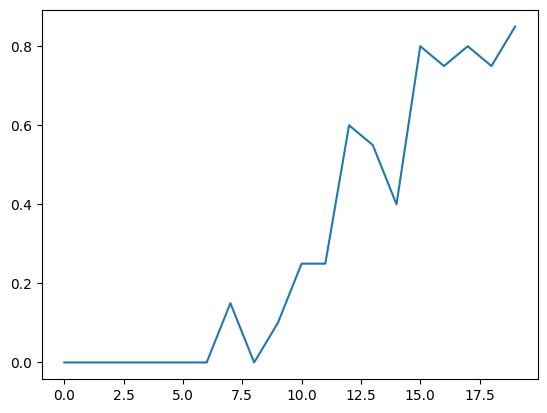

In [9]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(Rewards))],Rewards)